<a href="https://colab.research.google.com/github/Serurays/Explainable_AI/blob/main/Explainable_AI_Brain_Stroke_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Load the Dataset**

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d zzettrkalpakbal/full-filled-brain-stroke-dataset
!unzip full-filled-brain-stroke-dataset

mkdir: cannot create directory ‘/root/.kaggle’: File exists
full-filled-brain-stroke-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  full-filled-brain-stroke-dataset.zip
replace full_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: full_data.csv           
replace full_filled_stroke_data (1).csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: full_filled_stroke_data (1).csv  


In [ ]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Load the data
data = pd.read_csv('full_data.csv')

In [ ]:
# Show head
print(data.shape)
data.head()

(4981, 11)


gender   age  hypertension  heart_disease ever_married      work_type  \
0    Male  67.0             0              1          Yes        Private   
1    Male  80.0             0              1          Yes        Private   
2  Female  49.0             0              0          Yes        Private   
3  Female  79.0             1              0          Yes  Self-employed   
4    Male  81.0             0              0          Yes        Private   

  Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
0          Urban             228.69  36.6  formerly smoked       1  
1          Rural             105.92  32.5     never smoked       1  
2          Urban             171.23  34.4           smokes       1  
3          Rural             174.12  24.0     never smoked       1  
4          Urban             186.21  29.0  formerly smoked       1

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   object 
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   object 
 5   work_type          4981 non-null   object 
 6   Residence_type     4981 non-null   object 
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   object 
 10  stroke             4981 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 428.2+ KB


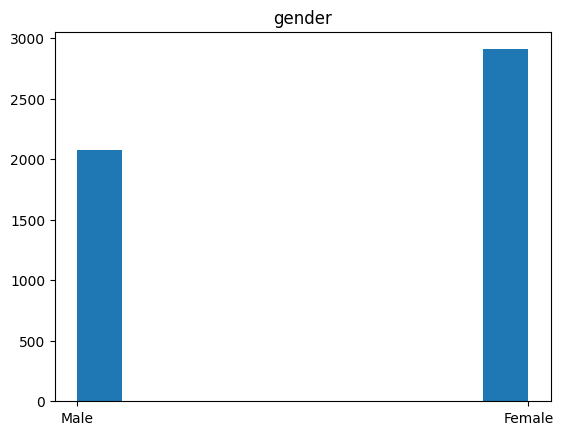

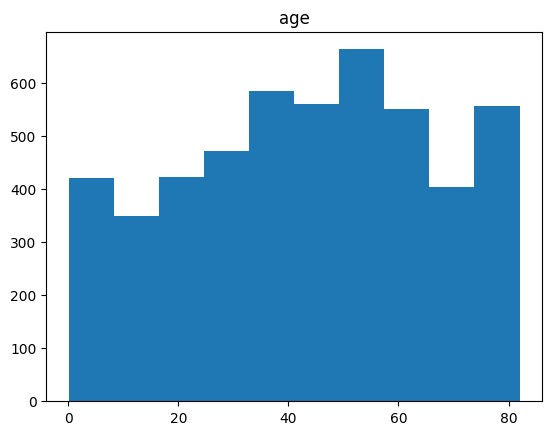

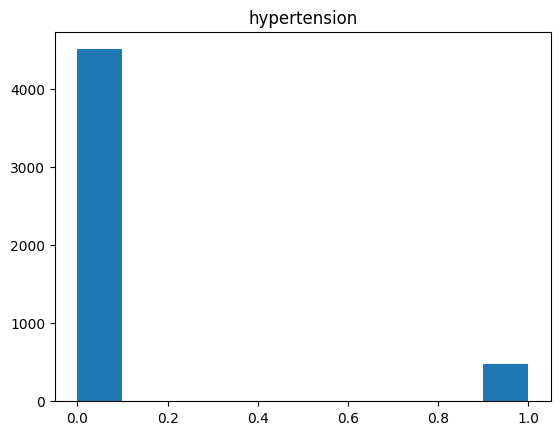

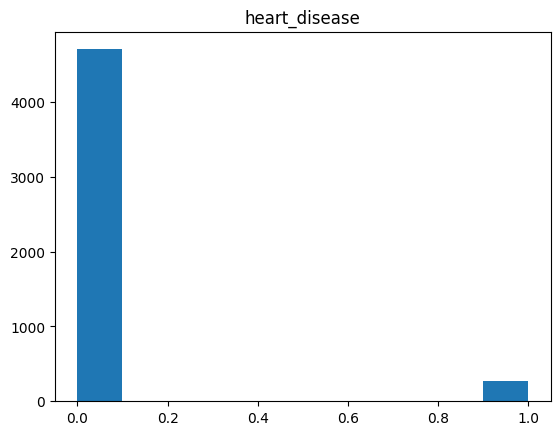

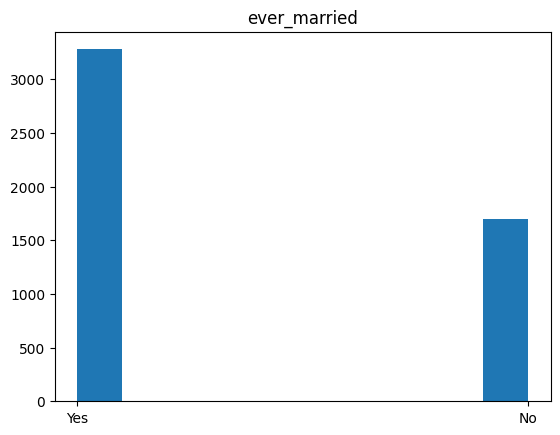

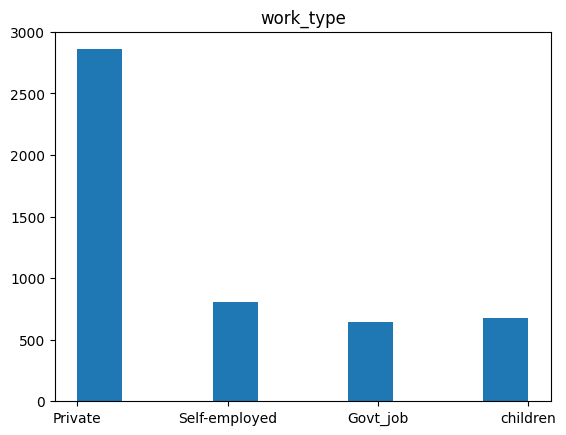

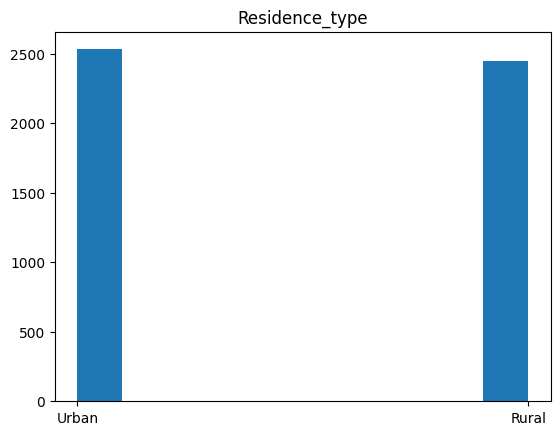

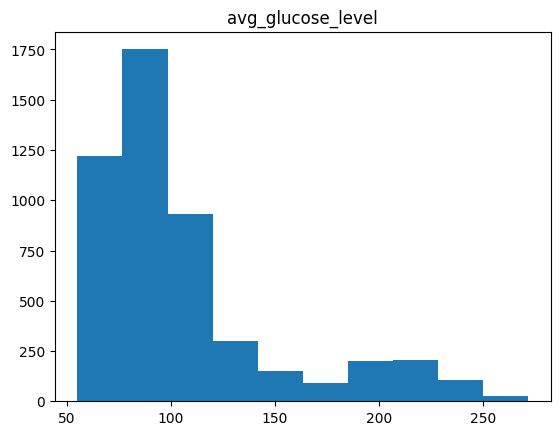

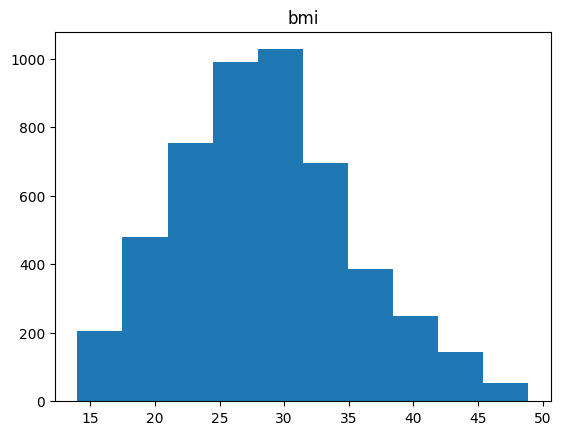

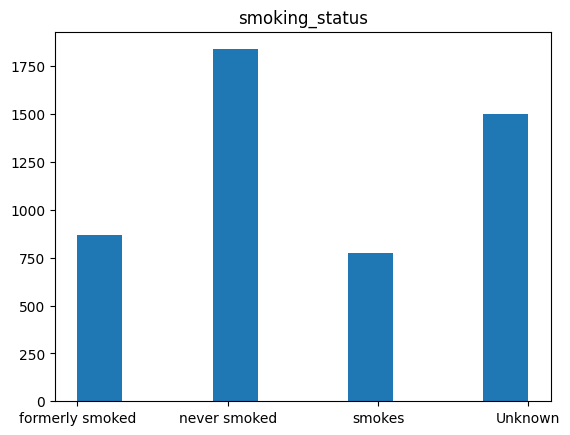

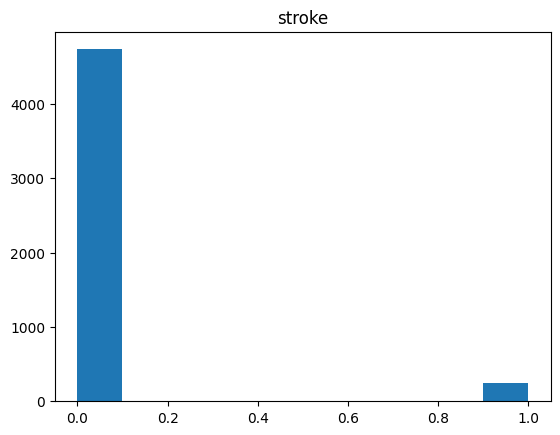

In [ ]:
# Histogram
columns = data.columns
for col in columns:
  plt.hist(data[col])
  plt.title(col)
  plt.show()

In [ ]:
# One-hot encode all categorical columns
categorical_cols = data.select_dtypes(include=['object']).columns
encoded = pd.get_dummies(data[categorical_cols], prefix=categorical_cols)

In [ ]:
data = pd.concat([data, encoded], axis=1)
data.drop(columns=categorical_cols, axis=1, inplace=True)

In [ ]:
# Input missing values of bmi
data['bmi'] = data['bmi'].fillna(data['bmi'].mean())

In [ ]:
data.columns

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'stroke', 'gender_Female', 'gender_Male', 'ever_married_No',
       'ever_married_Yes', 'work_type_Govt_job', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Rural',
       'Residence_type_Urban', 'smoking_status_Unknown',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes'],
      dtype='object')

In [ ]:
data.head()

age  hypertension  heart_disease  avg_glucose_level   bmi  stroke  \
0  67.0             0              1             228.69  36.6       1   
1  80.0             0              1             105.92  32.5       1   
2  49.0             0              0             171.23  34.4       1   
3  79.0             1              0             174.12  24.0       1   
4  81.0             0              0             186.21  29.0       1   

   gender_Female  gender_Male  ever_married_No  ever_married_Yes  \
0              0            1                0                 1   
1              0            1                0                 1   
2              1            0                0                 1   
3              1            0                0                 1   
4              0            1                0                 1   

   work_type_Govt_job  work_type_Private  work_type_Self-employed  \
0                   0                  1                        0   
1                   0                  1                        0   
2                   0                  1                        0   
3                   0                  0                        1   
4                   0                  1                        0   

   work_type_children  Residence_type_Rural  Residence_type_Urban  \
0                   0                     0                     1   
1                   0                     1                     0   
2                   0                     0                     1   
3                   0                     1                     0   
4                   0                     0                     1   

   smoking_status_Unknown  smoking_status_formerly smoked  \
0                       0                               1   
1                       0                               0   
2                       0                               0   
3                       0                               0   
4                       0                               1   

   smoking_status_never smoked  smoking_status_smokes  
0                            0                      0  
1                            1                      0  
2                            0                      1  
3                            1                      0  
4                            0                      0

# **Logistic Regression**

In [ ]:
from interpret.glassbox import (LogisticRegression,
                                ClassificationTree,
                                ExplainableBoostingClassifier)
from interpret import show
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
X = data.drop(columns=['stroke'])
y = data['stroke']

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from imblearn.over_sampling import RandomOverSampler
# Oversampling to solve class imbalance problem
oversample = RandomOverSampler(sampling_strategy='minority')

In [ ]:
# Convert to numpy and oversample
X_np = X_train.to_numpy()
y_np = y_train.to_numpy()
X_np, y_np = oversample.fit_resample(X_np, y_np)

In [ ]:
# Convert to pandas
X_train = pd.DataFrame(X_np, columns=X_train.columns)
y_train = pd.Series(y_np, name=y_train.name)

In [ ]:
# Fit logistic regression model
lr = LogisticRegression(random_state=2021, feature_names=X_train.columns, penalty='l1', solver='liblinear')
lr.fit(X_train, y_train)
print('Training finished!')

Training finished!


In [ ]:
# Evaluate logistic regression model
y_pred = lr.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average='macro'))

Accuracy: 0.7211634904714143
F1 score: 0.5367967538371036


In [ ]:
# Explain local prediction
lr_local = lr.explain_local(X_test[:100], y_test[:100], name='Logistic Regression')
show(lr_local)

In [ ]:
# Explain global logistic regression model
lr_global = lr.explain_global(name='Logistic Regression')
show(lr_global)

In [ ]:
# Fit decision tree model
dt = ClassificationTree()
dt.fit(X_train, y_train)
print('Training finished!')

Training finished!


In [ ]:
# Make predictions
y_pred = dt.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average='macro'))

Accuracy: 0.7422266800401204
F1 score: 0.5454297083592792


In [ ]:
# Local predictions
dt_local = dt.explain_local(X_test[:100], y_test[:100], name='Decision Tree')
show(dt_local)

In [ ]:
# Fit Explainable Boosting Machine
ebm = ExplainableBoostingClassifier(random_state=2021)
ebm.fit(X_train, y_train)
print('Training finished!')

Training finished!


In [ ]:
# Make predictions
y_pred = ebm.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average='macro'))

Accuracy: 0.9247743229689067
F1 score: 0.585515922507691


In [ ]:
# Explain locally
ebm_local = ebm.explain_local(X_test[:100], y_test[:100], name='Explainable Boosting Machine')
show(ebm_local)

In [ ]:
# Explain globally
ebm_global = ebm.explain_global(name='Explainable Boosting Machine')
show(ebm_global)

https://youtu.be/qPn9m30ojfc?si=em46-PmJ2QQc-6Vo

# **LIME**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from interpret.blackbox import LimeTabular

In [ ]:
# Fit the blackbox model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
# Predictions
y_pred = rf.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average='macro'))

Accuracy: 0.9297893681043129
F1 score: 0.4956786911781709


In [ ]:
# Initialize Lime for tabular data
lime = LimeTabular(model=rf.predict_proba, data=X_train, random_state=1)
# Get local explanations
lime_local = lime.explain_local(X_test[-20:], y_test[-20:], name='LIME')
show(lime_local)

https://youtu.be/d6j6bofhj2M?si=NhS7_ZZ6hjZXoeC1

# **SHAP**

In [ ]:
import shap

In [ ]:
# Create SHAP Explainer
explainer = shap.TreeExplainer(rf)
# Calculate shapley values for test data
start_index = 1
end_index = 2
shap_values = explainer.shap_values(X_test[start_index:end_index])
X_test[start_index:end_index]

age  hypertension  heart_disease  avg_glucose_level   bmi  \
3671  11.0             0              0              93.51  20.8   

      gender_Female  gender_Male  ever_married_No  ever_married_Yes  \
3671              1            0                1                 0   

      work_type_Govt_job  work_type_Private  work_type_Self-employed  \
3671                   0                  0                        0   

      work_type_children  Residence_type_Rural  Residence_type_Urban  \
3671                   1                     1                     0   

      smoking_status_Unknown  smoking_status_formerly smoked  \
3671                       1                               0   

      smoking_status_never smoked  smoking_status_smokes  
3671                            0                      0

In [ ]:
# class 0 -> contribution to class 1
# class 1 -> contribution to class 2
shap_values = shap_values[0].T
shap_values.shape

(2, 19)

In [ ]:
prediction = rf.predict(X_test[start_index:end_index])
prediction, prediction[0]

(array([0]), 0)

In [ ]:
# Visualize local predictions
shap.initjs()
# Force plot
prediction = rf.predict(X_test[start_index:end_index])[0]
print(f"The RF predicted: {prediction}")
shap.force_plot(explainer.expected_value[1],
                shap_values[1],
                X_test[start_index:end_index]) # for values

The RF predicted: 0


https://youtu.be/9haIOplEIGM?si=mPczjUAXf9ONNf1o

# **Counterfactual Explanations and Adversarial Attacks**

In [ ]:
import dice_ml

In [ ]:
# Dataset
data_dice = dice_ml.Data(
    dataframe=data,
    # For perturbation strategy
    continuous_features = ['age', 'bmi', 'avg_glucose_level'],
    outcome_name='stroke'
)

# Model
rf_dice = dice_ml.Model(
    model=rf,
    # There are backends for tf, torch, ..., but rf is from sklearn
    backend='sklearn'
)

explainer = dice_ml.Dice(
    data_dice,
    rf_dice,
    method='random'
    )

In [ ]:
# Generate CF
input_datapoint = X_test[0:1]
cf = explainer.generate_counterfactuals(
    input_datapoint,
    total_CFs=3,
    desired_class='opposite',
    # since we just have two classes
    )

100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


In [ ]:
# Visualize it
cf.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 0)


age  hypertension  heart_disease  avg_glucose_level   bmi  gender_Female  \
0  65.0             1              0         180.759995  26.9              1   

   gender_Male  ever_married_No  ever_married_Yes  work_type_Govt_job  \
0            0                0                 1                   0   

   work_type_Private  work_type_Self-employed  work_type_children  \
0                  1                        0                   0   

   Residence_type_Rural  Residence_type_Urban  smoking_status_Unknown  \
0                     0                     1                       1   

   smoking_status_formerly smoked  smoking_status_never smoked  \
0                               0                            0   

   smoking_status_smokes  stroke  
0                      0       0


Diverse Counterfactual set (new outcome: 1)


age hypertension heart_disease avg_glucose_level bmi gender_Female  \
0  81.4            -             -                 -   -           0.0   
1  71.2          0.0             -                 -   -             -   
2  71.2          0.0             -                 -   -             -   

  gender_Male ever_married_No ever_married_Yes work_type_Govt_job  \
0         1.0               -                -                  -   
1           -               -                -                  -   
2           -               -                -                  -   

  work_type_Private work_type_Self-employed work_type_children  \
0                 -                       -                  -   
1                 -                       -                  -   
2                 -                       -                  -   

  Residence_type_Rural Residence_type_Urban smoking_status_Unknown  \
0                    -                    -                      -   
1                  1.0                    -                      -   
2                  1.0                    -                      -   

  smoking_status_formerly smoked smoking_status_never smoked  \
0                              -                           -   
1                              -                           -   
2                              -                           -   

  smoking_status_smokes stroke  
0                     -    1.0  
1                     -      -  
2                     -      -

In [ ]:
# Create conditional counterfactuals
features_to_vary=['avg_glucose_level',
                  'bmi',
                  'smoking_status_smokes']

permitted_range={'avg_glucose_level':[50, 250],
                'bmi':[18, 35]}

cf = explainer.generate_counterfactuals(
    input_datapoint,
    total_CFs=3,
    desired_class='opposite',
    permitted_range=permitted_range,
    features_to_vary=features_to_vary
    )

cf.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

Query instance (original outcome : 0)


age  hypertension  heart_disease  avg_glucose_level   bmi  gender_Female  \
0  65.0             1              0         180.759995  26.9              1   

   gender_Male  ever_married_No  ever_married_Yes  work_type_Govt_job  \
0            0                0                 1                   0   

   work_type_Private  work_type_Self-employed  work_type_children  \
0                  1                        0                   0   

   Residence_type_Rural  Residence_type_Urban  smoking_status_Unknown  \
0                     0                     1                       1   

   smoking_status_formerly smoked  smoking_status_never smoked  \
0                               0                            0   

   smoking_status_smokes  stroke  
0                      0       0


Diverse Counterfactual set (new outcome: 1)


age hypertension heart_disease avg_glucose_level bmi gender_Female  \
0   -            -             -             62.37   -             -   
1   -            -             -             62.53   -             -   
2   -            -             -             62.37   -             -   

  gender_Male ever_married_No ever_married_Yes work_type_Govt_job  \
0           -               -                -                  -   
1           -               -                -                  -   
2           -               -                -                  -   

  work_type_Private work_type_Self-employed work_type_children  \
0                 -                       -                  -   
1                 -                       -                  -   
2                 -                       -                  -   

  Residence_type_Rural Residence_type_Urban smoking_status_Unknown  \
0                    -                    -                      -   
1                    -                    -                      -   
2                    -                    -                      -   

  smoking_status_formerly smoked smoking_status_never smoked  \
0                              -                           -   
1                              -                           -   
2                              -                           -   

  smoking_status_smokes stroke  
0                     -    1.0  
1                     -    1.0  
2                     -    1.0

https://youtu.be/UUZxRct8rIk?si=DVIpCxMKookDTJbo